# Visualizing the Variability of Sea Surface Temperatures in the Northern Pacific Using a Rasberry Pi

The goal of this project was to visualize the variability of sea surface temperature in the northern Pacific economically. This was achieved using 

### Big Picture
The results of this notebook are a part of a project titled "Signatures of the multiple scales of motion in shaping marine phytoplankton biogeography", whose goal is, as described by its proposal, "to address the nature of the interplay between ocean dynamics and marine plankton community structure."

### Smaller Picture
Using sea surface temperatures collected by (WHO???), three plots were created to visaulize the variabilty of sea surface temperatures. The data was convolved: put through a filter that reassigned each array element to the average of the 81 elements around it (9x9 square). Each element of the new array (conv) was subtracted from the corresponding element of the original array (sst), and the difference was stored into a final array (diff). The plotted difference reveals what areas of the ocean have the most variability in its sea surface temperature.

Additionaly, this project can be done for around 100 dollars, provided one does not already own any of the required materials. If one only needs to purchase the Raspberry Pi, the price drops to ~35 dollars
___
## Textbook
The following links were my "textbook" for this project
* Edx Python course based on the intro to computer science class at MIT
  * https://www.edx.org/course/introduction-to-computer-science-and-programming-using-python
* Linux course from The Linux Foundation, useful for navigating MGHPCC when logging in remotely
  * https://courses.edx.org/courses/course-v1:LinuxFoundationX+LFS101x+1T2017/course/
* GitIt: a git tutorial
  * https://github.com/jlord/git-it-electron
* NetCDF helper links
  * documentation: https://www.unidata.ucar.edu/software/netcdf/docs/
  * a doc I found more readable: http://unidata.github.io/netcdf4-python/
___
## Making plots

### First Thing's First

We have lots of modules to import:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import netCDF4
import astropy
import scipy
import calendar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.convolution import convolve as ap_convolve
from astropy.convolution import Box2DKernel
from matplotlib.axes import Axes
from netCDF4 import num2date
from scipy import stats

These data files are in Network Common Data form (netCDF). NetCDF files are structured similarly to the Unix file system, with a designated file acting as the "root group". The following function extracts data from the root group.

In [31]:
def extract_data(file):
    # Extract data from file
    sst=file['analysed_sst']
    date_num = file['time'][:]
    units = file.variables['time'].units
    date = num2date(date_num, units)[0]
    date = str(date)
    date = date[:10]

    # Extract a subregion
    sstReg=sst[0, ylo:yhi, xlo:xhi]-273.

    # Extract coordinate data
    lat = file.variables['lat']
    lon = file.variables['lon']
    latmin = (ylo/100) + lat.valid_min
    lonmin = (xlo/100) + lon.valid_min
    latmax = (yhi/100) + lat.valid_min
    lonmax = (xhi/100) + lon.valid_min
    file_info = (sstReg, date, latmin, lonmin, latmax, lonmax)
    return file_info

Then, the user chooses the x and y ranges they would like plots for and the file they would like to look at. 

*For these examples, we will be looking at data from the file "20130109090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"*

In [32]:
os.chdir('/nfs/cnhlab003/cnh/mur-sst')

# Choose x and y range
yhi = 15000
ylo = 10800
xhi = 3500
xlo = 1000

tFile = netCDF4.Dataset('20130109090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
tFile_info=extract_data(tFile)
sstReg, date=tFile_info[0], tFile_info[1]
latmin, lonmin=tFile_info[2], tFile_info[3]
latmax, lonmax=tFile_info[4], tFile_info[5]

Here is the documenation of the code we will use to make general plots. The first if statement is to be used when the researcher only wants to make one plot of one dataset. The second is when the researcher would like the final image to be composed of multiple plots.

In [33]:
def make_plot(data, num, cc, plttitle, vmin_val, vmax_val):
    if num == None:
        fig=plt.imshow(data, origin='lower', cmap=cc, vmin=vmin_val, vmax=vmax_val)
        plt.xticks([0, xhi-xlo], [lonmin, lonmax])
        plt.yticks([0, (yhi-ylo)/2, yhi-ylo], [latmin, ((latmax-latmin)/2)+latmin, latmax])
        plt.tick_params(axis='both', labelsize=7)
        plt.title(plttitle, size=14)
        plt.colorbar(fig)
    else:
        ax=plt.subplot(num)
        fig=plt.imshow(data, origin='lower', cmap=cc, vmin=vmin_val, vmax=vmax_val)
        plt.xticks([0, xhi-xlo], [lonmin, lonmax])
        plt.yticks([0, (yhi-ylo)/2, yhi-ylo], [latmin, ((latmax-latmin)/2)+latmin, latmax])
        ax.tick_params(axis='both', labelsize=7)
        plt.title(plttitle, size=10)

        # Make colorbar lined up with figure and resize label
        divider=make_axes_locatable(ax)
        cax=divider.append_axes("right", size="5%", pad=0.05)
        cbar=plt.colorbar(fig, cax=cax)
        ticklabs=cbar.ax.get_yticklabels()
        cbar.ax.set_yticklabels(ticklabs, fontsize=7)

### SST Plot

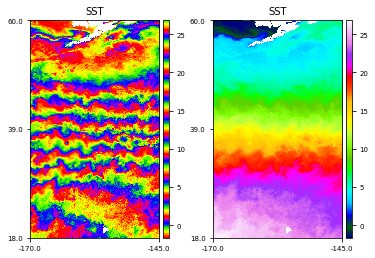

In [34]:
make_plot(sstReg, 121, 'prism', 'SST', None, None)
make_plot(sstReg, 122, 'gist_ncar', 'SST', None, None)

### Convolved Sea Surface Temperature Plot
The sea surface temperature was convolved over the 9x9 array surrounding each point. This set each point to the value of the average of the points around it.

In [25]:
def conv_for_vis(data, size):
    box_2D_kernel = Box2DKernel(size)
    nan=float('nan')
    data=np.ma.filled(data,nan)
    data[ :, 0]=nan
    data[ 0, :]=nan
    data[ :,-1]=nan
    data[-1, :]=nan
    data2=ap_convolve(data, box_2D_kernel)
    conv=data2
    conv=conv[size:-size, size:-size]
    conv=np.ma.masked_invalid(conv)
    return conv

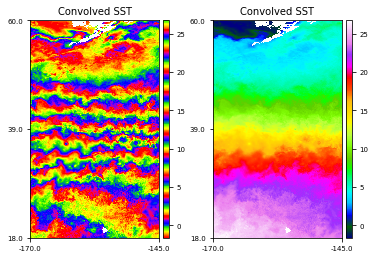

In [26]:
conv = conv_for_vis(sstReg, 9)
make_plot(conv, 121, 'prism', 'Convolved SST', None, None)
make_plot(conv, 122, 'gist_ncar', 'Convolved SST', None, None)

### Difference Plot
Plot of convolved data subtracted from original data

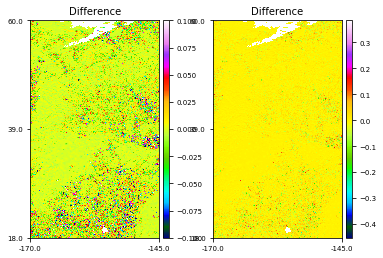

In [27]:
sstReg=sstReg[9:-9, 9:-9]
dif = sstReg - conv
make_plot(dif, 121, 'gist_ncar',  'Difference', -0.1, 0.1)
make_plot(dif, 122, 'gist_ncar',  'Difference', None, None)

"[^]: https://www.unidata.ucar.edu/software/netcdf/docs/"

___
## Histograms

In [9]:
def make_hist(data, num):
    if num != None:
        ax = plt.subplot(num)
        ax.tick_params(axis='both', labelsize=7)
    phi = data.flatten()
    hist = plt.hist(phi, bins=50)
        
    # sst labels change to phi see if no str works, look at format statments
    dmax = np.nanmax(phi)
    dmin = np.nanmin(phi)
    dmean = np.nanmean(phi)    
    dstd = np.nanstd(phi)
    dskew = stats.mstats.skew(phi, axis=None)
    dkurt = stats.mstats.kurtosis(phi, axis=None)
    plt.xlabel(f'max: {dmax:.3f}\n min: {dmin:.3f}\n mean: {dmean:.3f}\n std: {dstd:.3f}\n skew: {dskew:.3f}\n kurtosis: {dkurt:.3f}', size=7)

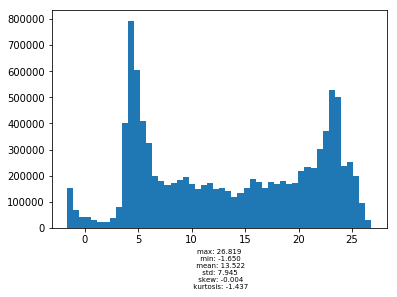

In [10]:
make_hist(sstReg, None)

___
## Final

/home/culberta/hill-2018/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/culberta/hill-2018/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


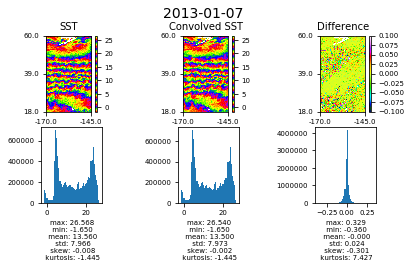

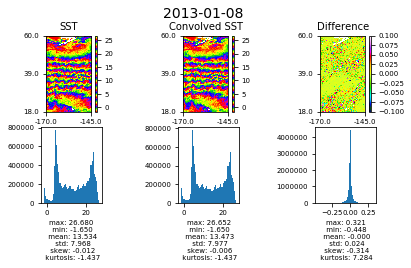

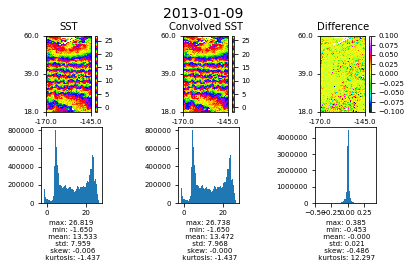

<Figure size 432x288 with 0 Axes>

In [14]:
os.chdir('/nfs/cnhlab003/cnh')
for filename in os.listdir('mur-sst'):
        if filename[:8] == '20130109' or filename[:8] == '20130108' or filename[:8] == '20130107':   
            boxsize=9

            # Choose x and y range
            yhi = 15000
            ylo = 10800
            xhi = 3500
            xlo = 1000

            # Create "handle" to access netCDF file
            tFile = netCDF4.Dataset('mur-sst/'+filename)
            extract_data(tFile)
            
            tFile_info=extract_data(tFile)
            sstReg, date=tFile_info[0], tFile_info[1]
            latmin, lonmin=tFile_info[2], tFile_info[3]
            latmax, lonmax=tFile_info[4], tFile_info[5]
            
            # Make sst data plots
            make_plot(sstReg, 231, 'prism', 'SST', None, None)
            make_hist(sstReg, 234)

            # Convolve sst data
            conv = conv_for_vis(sstReg, boxsize)

            # Make convolved data plots
            make_plot(conv, 232, 'prism', 'Convolved SST', None, None)
            make_hist(conv, 235)

            # Find difference between original and convolved data
            sstReg=sstReg[boxsize:-boxsize, boxsize:-boxsize]
            dif = sstReg - conv

            # Difference data plots
            make_plot(dif, 233, 'gist_ncar',  'Difference', -0.1, 0.1)
            dif = dif[np.logical_not(np.isnan(dif))] # Removes nan values from histogram
            make_hist(dif, 236)

            # Format plots
            plt.suptitle(date, fontsize=14)
            plt.subplots_adjust(wspace = 1.25, bottom = 0.3)

            # Save and show fig
            month = calendar.month_name[int(filename[4:6])]
            os.chdir('/home/culberta/public_html/sstconvdif-imgs-2012/'+month)
            plt.savefig(str(date) + '.png', dpi = 200)
            plt.show()
            plt.clf()
            os.chdir('/nfs/cnhlab003/cnh')